# Ensemble Training and Voting Mechanisms

This notebook implements ensemble methods to combine predictions from multiple DQN agents.


In [1]:
import os
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import deque
import warnings

warnings.filterwarnings('ignore')

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


## Load Data and Configuration

In [3]:
train_df = pd.read_parquet('data/processed/SPY_train.parquet')
val_df = pd.read_parquet('data/processed/SPY_val.parquet')

with open('models/feature_groups.json') as f:
    feature_groups = json.load(f)

available_norm = [c for c in train_df.columns if '_norm' in c]

print(f"Train: {train_df.shape}")
print(f"Val: {val_df.shape}")
print(f"Available normalized features: {len(available_norm)}")

Train: (1209, 27)
Val: (254, 27)
Available normalized features: 8


In [4]:
from trading_env import TradingEnv

import gymnasium as gym
print(f"Gymnasium version: {gym.__version__}")

Gymnasium version: 1.2.3


In [5]:
model_configs = {
    'simple_dqn': {'features': 'momentum', 'episodes': 50},
    'dropout_dqn': {'features': 'volatility', 'episodes': 50},
    'residual_dqn': {'features': 'volume', 'episodes': 50},
    'dueling_dqn': {'features': 'trend', 'episodes': 50},
    'lstm_dqn': {'features': 'all', 'episodes': 50},
    'attention_dqn': {'features': 'all', 'episodes': 50}
}

print("Model Training Plan:")
for name, cfg in model_configs.items():
    n_feats = len([f for f in feature_groups[cfg['features']] if f in available_norm])
    print(f"{name}: {cfg['features']} ({n_feats} features, {cfg['episodes']} episodes)")

Model Training Plan:
simple_dqn: momentum (2 features, 50 episodes)
dropout_dqn: volatility (2 features, 50 episodes)
residual_dqn: volume (2 features, 50 episodes)
dueling_dqn: trend (2 features, 50 episodes)
lstm_dqn: all (8 features, 50 episodes)
attention_dqn: all (8 features, 50 episodes)


## Replay Buffer Implementation

The replay buffer stores state, action, reward, next_state, done for off-policy learning. This breaks temporal correlations and improves sample efficiency.

In [6]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            np.array(state), 
            np.array(action), 
            np.array(reward, dtype=np.float32), 
            np.array(next_state), 
            np.array(done, dtype=np.uint8)
        )
    
    def __len__(self):
        return len(self.buffer)

## DQN Agent with Target Network

1. **Policy Network**: Selects actions based on current Q-values
2. **Target Network**: Provides stable targets for Q-learning updates
3. **Epsilon-greedy exploration**: Balances exploration vs exploitation

The target network is updated every target_update episodes to stabilize training.

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size, model_class, lr=1e-3, 
                 gamma=0.99, buffer_size=20000, target_update=10):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = gamma
        self.target_update = target_update
        
        self.policy_net = model_class(state_size, action_size).to(device)
        self.target_net = model_class(state_size, action_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr)
        self.memory = ReplayBuffer(buffer_size)

    def select_action(self, state, epsilon=0.0):
        if random.random() < epsilon:
            return random.randint(0, self.action_size - 1)
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self.policy_net(state)
        return q_values.argmax().item()
    
    def step(self, state, action, reward, next_state, done):
        self.memory.push(state, action, reward, next_state, done)

    def update(self, batch_size):
        if len(self.memory) < batch_size:
            return None
        
        states, actions, rewards, next_states, dones = self.memory.sample(batch_size)
        
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)
        
        current_q = self.policy_net(states).gather(1, actions)
        
        with torch.no_grad():
            next_q = self.target_net(next_states).max(1)[0].unsqueeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        loss = F.mse_loss(current_q, target_q)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())
    
    def save(self, path):
        torch.save(self.policy_net.state_dict(), path)
    
    def load(self, path):
        self.policy_net.load_state_dict(torch.load(path, map_location=device))
        self.target_net.load_state_dict(self.policy_net.state_dict())

## Training Function

Extended training with 50 episodes (vs 20 in Week 4).
Epsilon decays from 1.0 to 0.01 with decay rate 0.98 per episode.

In [8]:
def train_agent(agent, env, n_episodes, batch_size=64, 
                epsilon_start=1.0, epsilon_end=0.01, decay=0.98):
    history = {'rewards': [], 'portfolio_values': [], 'losses': []}
    epsilon = epsilon_start
    
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        losses = []
        
        while not done:
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _, info = env.step(action)
            
            agent.step(state, action, reward, next_state, done)
            loss = agent.update(batch_size)
            if loss:
                losses.append(loss)
            
            state = next_state
            total_reward += reward
        
        if episode % agent.target_update == 0:
            agent.update_target()
        
        epsilon = max(epsilon_end, epsilon * decay)
        
        avg_loss = np.mean(losses) if losses else 0
        history['rewards'].append(total_reward)
        history['portfolio_values'].append(info['portfolio_value'])
        history['losses'].append(avg_loss)
        
        if (episode + 1) % 10 == 0:
            print(f"Ep {episode+1}/{n_episodes}: "
                  f"Reward={total_reward:.1f}, Value=${info['portfolio_value']:.0f}, "
                  f"Eps={epsilon:.3f}, Loss={avg_loss:.3f}")
    
    return history

## Model Architecture Definitions

Each architecture is designed with specific theoretical motivations.

In [9]:
class SimpleDQN(nn.Module):
    """Basic 3-layer network. Good baseline for comparison."""
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
        nn.init.xavier_uniform_(self.fc1.weight, gain=0.5)
        nn.init.xavier_uniform_(self.fc2.weight, gain=0.5)
        nn.init.xavier_uniform_(self.fc3.weight, gain=0.5)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [10]:
class SimpleDropoutDQN(nn.Module):
    """Dropout for regularization. Helps prevent overfitting on noisy volatility features."""
    def __init__(self, state_size, action_size, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(128, 64)
        self.drop2 = nn.Dropout(dropout * 0.5)
        self.fc3 = nn.Linear(64, action_size)
        nn.init.xavier_uniform_(self.fc1.weight, gain=0.5)
        nn.init.xavier_uniform_(self.fc2.weight, gain=0.5)
        nn.init.xavier_uniform_(self.fc3.weight, gain=0.5)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.drop1(x)
        x = F.relu(self.fc2(x))
        x = self.drop2(x)
        return self.fc3(x)

In [11]:
class SimpleResidualDQN(nn.Module):
    """Skip connections help gradient flow. Useful for volume features which may have
    complex non-linear relationships with price movements."""
    def __init__(self, state_size, action_size):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)
        for m in [self.fc1, self.fc2, self.fc3]:
            nn.init.xavier_uniform_(m.weight, gain=0.5)
    
    def forward(self, x):
        out = F.relu(self.fc1(x))
        residual = out
        out = F.relu(self.fc2(out))
        out = out + residual
        return self.fc3(out)

In [12]:
class DuelingDQN(nn.Module):
    """Separates state value V(s) from action advantage A(s,a).
    Q(s,a) = V(s) + A(s,a) - mean(A).
    This helps when actions don't affect value much (common in trending markets)."""
    def __init__(self, state_size, action_size):
        super().__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_size, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU()
        )
        self.value = nn.Sequential(
            nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, 1)
        )
        self.advantage = nn.Sequential(
            nn.Linear(128, 128), nn.ReLU(), nn.Linear(128, action_size)
        )
        for module in [self.feature, self.value, self.advantage]:
            for m in module.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight, gain=0.5)
    
    def forward(self, x):
        f = self.feature(x)
        v = self.value(f)
        a = self.advantage(f)
        return v + (a - a.mean(dim=1, keepdim=True))

In [13]:
class LSTMDQN(nn.Module):
    """LSTM captures temporal dependencies in sequential data.
    Can learn patterns like 'RSI oversold for 3 days -> likely reversal'."""
    def __init__(self, state_size, action_size, hidden=128):
        super().__init__()
        self.lstm = nn.LSTM(state_size, hidden, num_layers=2, 
                          batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(hidden, 128), nn.ReLU(), nn.Linear(128, action_size)
        )
        for name, param in self.lstm.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
    
    def forward(self, x, hidden=None):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        out, hidden = self.lstm(x, hidden)
        return self.fc(out[:, -1, :])

In [14]:
class AttentionDQN(nn.Module):
    """Self-attention allows the model to focus on important time steps.
    Useful for identifying key market events in the sequence."""
    def __init__(self, state_size, action_size, embed=128, heads=4):
        super().__init__()
        self.embed = nn.Linear(state_size, embed)
        self.attn = nn.MultiheadAttention(embed, heads, batch_first=True, dropout=0.1)
        self.fc = nn.Sequential(
            nn.Linear(embed, 128), nn.ReLU(), nn.Dropout(0.1),
            nn.Linear(128, action_size)
        )
        nn.init.xavier_uniform_(self.embed.weight, gain=0.5)
        for m in self.fc.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
    
    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        e = self.embed(x)
        a, _ = self.attn(e, e, e)
        out = (e + a).mean(dim=1)
        return self.fc(out)

In [15]:
model_classes = {
    'simple_dqn': SimpleDQN,
    'dropout_dqn': SimpleDropoutDQN,
    'residual_dqn': SimpleResidualDQN,
    'dueling_dqn': DuelingDQN,
    'lstm_dqn': LSTMDQN,
    'attention_dqn': AttentionDQN
}

## Sequence Wrapper for LSTM/Attention

These models require a sequence of past observations to capture temporal patterns.

In [16]:
class SequenceWrapper:
    """Wraps environment to return sequences of observations."""
    def __init__(self, env, seq_len=10):
        self.env = env
        self.seq_len = seq_len
        self.history = deque(maxlen=seq_len)
        self.state_dim = env.state_dim
        self.action_space = env.action_space
    
    def reset(self, **kwargs):
        state, info = self.env.reset(**kwargs)
        for _ in range(self.seq_len):
            self.history.append(state)
        return np.array(self.history), info
    
    def step(self, action):
        next_state, reward, done, truncated, info = self.env.step(action)
        self.history.append(next_state)
        return np.array(self.history), reward, done, truncated, info

## Train Simple DQN

Using momentum features (RSI, MACD) which are well-suited for a simple Q-network.

In [17]:
name = 'simple_dqn'
cfg = model_configs[name]
features = [f for f in feature_groups[cfg['features']] if f in available_norm]

env = TradingEnv(train_df, feature_columns=features)
agent = DQNAgent(env.state_dim, 3, model_classes[name], lr=1e-3, target_update=10)

print(f"Training {name} with {cfg['episodes']} episodes...")
history_simple = train_agent(agent, env, cfg['episodes'])
agent.save(f'models/{name}_v2.pt')
print(f"Final value: ${history_simple['portfolio_values'][-1]:.2f}")

Training simple_dqn with 50 episodes...
Ep 10/50: Reward=-52.7, Value=$8165, Eps=0.817, Loss=0.250
Ep 20/50: Reward=-58.2, Value=$8138, Eps=0.668, Loss=0.242
Ep 30/50: Reward=-0.4, Value=$12440, Eps=0.545, Loss=0.230
Ep 40/50: Reward=11.3, Value=$14372, Eps=0.446, Loss=0.225
Ep 50/50: Reward=38.3, Value=$18010, Eps=0.364, Loss=0.202
Final value: $18010.30


## Train Dropout DQN

Using volatility features (ATR, BB_Width) with dropout regularization.

In [18]:
name = 'dropout_dqn'
cfg = model_configs[name]
features = [f for f in feature_groups[cfg['features']] if f in available_norm]

env = TradingEnv(train_df, feature_columns=features)
agent = DQNAgent(env.state_dim, 3, model_classes[name], lr=1e-3, target_update=10)

print(f"Training {name}...")
history_dropout = train_agent(agent, env, cfg['episodes'])
agent.save(f'models/{name}_v2.pt')
print(f"Final value: ${history_dropout['portfolio_values'][-1]:.2f}")

Training dropout_dqn...
Ep 10/50: Reward=-10.6, Value=$10678, Eps=0.817, Loss=0.247
Ep 20/50: Reward=-16.2, Value=$12756, Eps=0.668, Loss=0.269
Ep 30/50: Reward=23.5, Value=$14854, Eps=0.545, Loss=0.301
Ep 40/50: Reward=21.0, Value=$14047, Eps=0.446, Loss=0.334
Ep 50/50: Reward=35.9, Value=$16503, Eps=0.364, Loss=0.349
Final value: $16502.54


## Train Residual DQN

Using volume features (OBV, Volume) with skip connections.

In [19]:
name = 'residual_dqn'
cfg = model_configs[name]
features = [f for f in feature_groups[cfg['features']] if f in available_norm]

env = TradingEnv(train_df, feature_columns=features)
agent = DQNAgent(env.state_dim, 3, model_classes[name], lr=1e-3, target_update=10)

print(f"Training {name}...")
history_residual = train_agent(agent, env, cfg['episodes'])
agent.save(f'models/{name}_v2.pt')
print(f"Final value: ${history_residual['portfolio_values'][-1]:.2f}")

Training residual_dqn...
Ep 10/50: Reward=-52.7, Value=$9355, Eps=0.817, Loss=0.237
Ep 20/50: Reward=-19.3, Value=$11604, Eps=0.668, Loss=0.222
Ep 30/50: Reward=29.6, Value=$14138, Eps=0.545, Loss=0.231
Ep 40/50: Reward=48.8, Value=$18993, Eps=0.446, Loss=0.257
Ep 50/50: Reward=50.2, Value=$16891, Eps=0.364, Loss=0.254
Final value: $16890.80


## Train Dueling DQN

Using trend features (Dist_SMA20, Dist_SMA50) with value/advantage separation.

In [20]:
name = 'dueling_dqn'
cfg = model_configs[name]
features = [f for f in feature_groups[cfg['features']] if f in available_norm]

env = TradingEnv(train_df, feature_columns=features)
agent = DQNAgent(env.state_dim, 3, model_classes[name], lr=1e-3, target_update=10)

print(f"Training {name}...")
history_dueling = train_agent(agent, env, cfg['episodes'])
agent.save(f'models/{name}_v2.pt')
print(f"Final value: ${history_dueling['portfolio_values'][-1]:.2f}")

Training dueling_dqn...
Ep 10/50: Reward=-58.7, Value=$8810, Eps=0.817, Loss=0.177
Ep 20/50: Reward=-22.3, Value=$11383, Eps=0.668, Loss=0.155
Ep 30/50: Reward=15.3, Value=$14503, Eps=0.545, Loss=0.152
Ep 40/50: Reward=39.9, Value=$16374, Eps=0.446, Loss=0.148
Ep 50/50: Reward=89.1, Value=$16398, Eps=0.364, Loss=0.139
Final value: $16398.01


## Train LSTM DQN

Using all features with sequence wrapper for temporal modeling.

In [21]:
name = 'lstm_dqn'
cfg = model_configs[name]
features = [f for f in feature_groups[cfg['features']] if f in available_norm]

base_env = TradingEnv(train_df, feature_columns=features)
env = SequenceWrapper(base_env, seq_len=10)

agent = DQNAgent(base_env.state_dim, 3, model_classes[name], lr=1e-3, target_update=10)

print(f"Training {name} with sequences...")
history_lstm = train_agent(agent, env, cfg['episodes'])
agent.save(f'models/{name}_v2.pt')
print(f"Final value: ${history_lstm['portfolio_values'][-1]:.2f}")

Training lstm_dqn with sequences...
Ep 10/50: Reward=-19.1, Value=$12070, Eps=0.817, Loss=0.042
Ep 20/50: Reward=13.2, Value=$13342, Eps=0.668, Loss=0.044
Ep 30/50: Reward=50.0, Value=$17633, Eps=0.545, Loss=0.039
Ep 40/50: Reward=93.2, Value=$24494, Eps=0.446, Loss=0.028
Ep 50/50: Reward=167.9, Value=$31789, Eps=0.364, Loss=0.019
Final value: $31788.94


## Train Attention DQN

Using all features with self-attention mechanism.

In [22]:
name = 'attention_dqn'
cfg = model_configs[name]
features = [f for f in feature_groups[cfg['features']] if f in available_norm]

base_env = TradingEnv(train_df, feature_columns=features)
env = SequenceWrapper(base_env, seq_len=10)

agent = DQNAgent(base_env.state_dim, 3, model_classes[name], lr=1e-3, target_update=10)

print(f"Training {name}...")
history_attention = train_agent(agent, env, cfg['episodes'])
agent.save(f'models/{name}_v2.pt')
print(f"Final value: ${history_attention['portfolio_values'][-1]:.2f}")

Training attention_dqn...
Ep 10/50: Reward=-29.9, Value=$11979, Eps=0.817, Loss=0.187
Ep 20/50: Reward=-45.9, Value=$9435, Eps=0.668, Loss=0.184
Ep 30/50: Reward=29.8, Value=$17975, Eps=0.545, Loss=0.168
Ep 40/50: Reward=33.4, Value=$15794, Eps=0.446, Loss=0.168
Ep 50/50: Reward=79.2, Value=$26939, Eps=0.364, Loss=0.171
Final value: $26939.20


## Compare Training Results

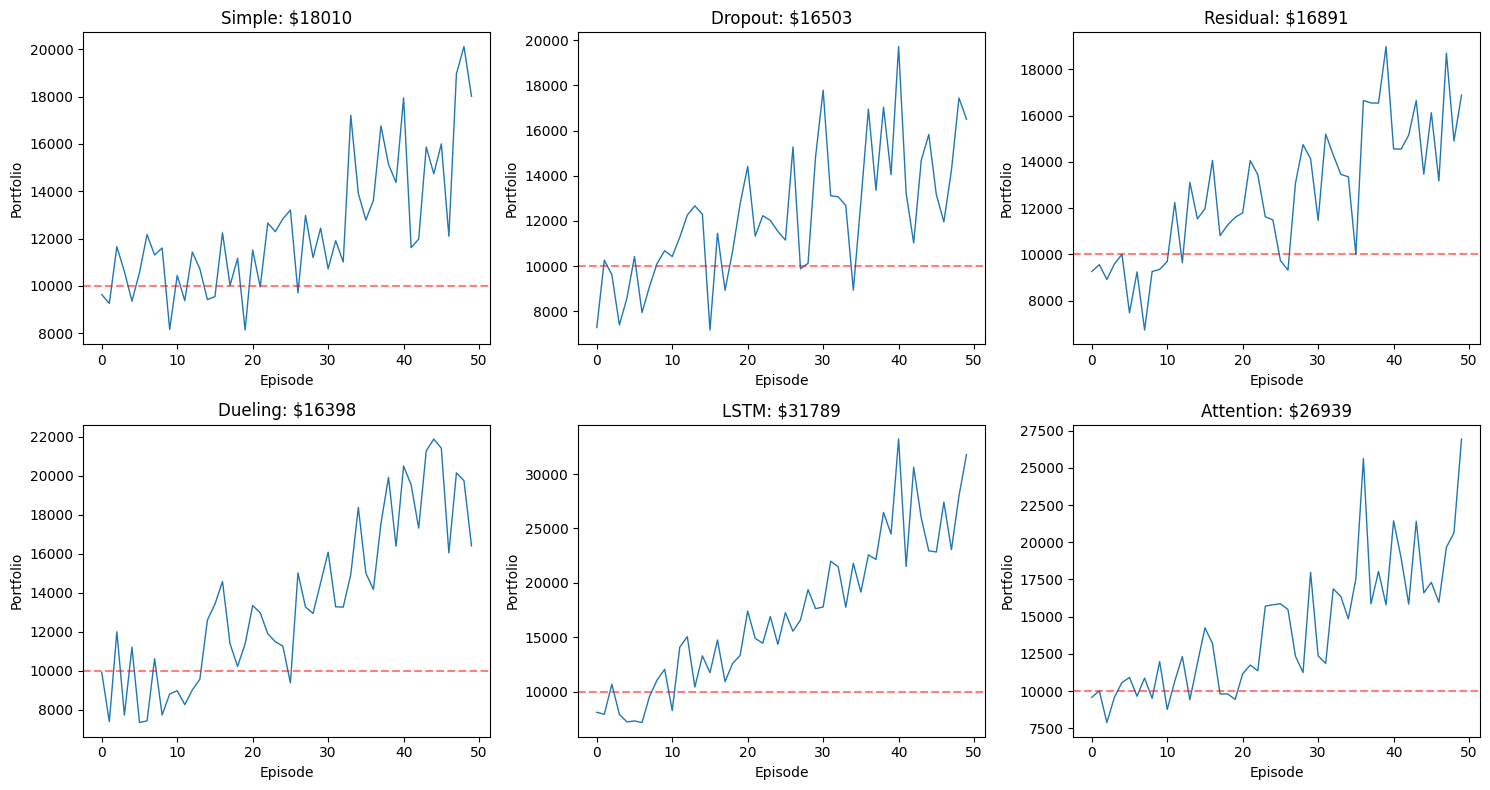

In [23]:
histories = {
    'Simple': history_simple,
    'Dropout': history_dropout,
    'Residual': history_residual,
    'Dueling': history_dueling,
    'LSTM': history_lstm,
    'Attention': history_attention
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (name, hist) in enumerate(histories.items()):
    ax = axes[idx]
    ax.plot(hist['portfolio_values'], linewidth=1)
    ax.axhline(10000, color='red', linestyle='--', alpha=0.5)
    ax.set_title(f'{name}: ${hist["portfolio_values"][-1]:.0f}')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Portfolio')

plt.tight_layout()
plt.show()

In [24]:
summary = []
for name, hist in histories.items():
    summary.append({
        'Model': name,
        'Final Value': hist['portfolio_values'][-1],
        'Best Value': max(hist['portfolio_values']),
        'Final Loss': hist['losses'][-1]
    })

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

    Model  Final Value   Best Value  Final Loss
   Simple 18010.299232 20112.518838    0.202107
  Dropout 16502.537021 19725.737863    0.348620
 Residual 16890.803183 18992.704809    0.254129
  Dueling 16398.013335 21875.044503    0.139320
     LSTM 31788.943827 33216.818782    0.018976
Attention 26939.196568 26939.196568    0.171334


## Load All Trained Models for Ensemble

In [25]:
models = {}
model_paths = {
    'simple_dqn': 'models/simple_dqn_v2.pt',
    'dropout_dqn': 'models/dropout_dqn_v2.pt',
    'residual_dqn': 'models/residual_dqn_v2.pt',
    'dueling_dqn': 'models/dueling_dqn_v2.pt',
    'lstm_dqn': 'models/lstm_dqn_v2.pt',
    'attention_dqn': 'models/attention_dqn_v2.pt'
}

for name, path in model_paths.items():
    if os.path.exists(path):
        cfg = model_configs[name]
        features = [f for f in feature_groups[cfg['features']] if f in available_norm]
        
        env = TradingEnv(train_df, feature_columns=features)
        agent = DQNAgent(env.state_dim, 3, model_classes[name], lr=1e-3)
        agent.load(path)
        models[name] = agent
        print(f"Loaded {name}")
    else:
        print(f"Missing {name}")

print(f"\nLoaded {len(models)} models for ensemble")

Loaded simple_dqn
Loaded dropout_dqn
Loaded residual_dqn
Loaded dueling_dqn
Loaded lstm_dqn
Loaded attention_dqn

Loaded 6 models for ensemble


## Hard Voting Ensemble

Each model votes for an action. The action with the most votes wins.

This is Simple and interpretable. Works well when models have diverse strengths

In [26]:
from collections import Counter

class HardVotingEnsemble:
    def __init__(self, models, model_configs, feature_groups, available_norm):
        self.models = models
        self.configs = model_configs
        self.feature_groups = feature_groups
        self.available_norm = available_norm
    
    def get_action(self, state_by_model):
        votes = []
        
        for name, agent in self.models.items():
            state = state_by_model[name]
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = agent.policy_net(state_t)
                action = q_values.argmax().item()
            votes.append(action)
        
        vote_counts = Counter(votes)
        return vote_counts.most_common(1)[0][0], votes

## Soft Voting Ensemble

Averages Q-values across models, then takes argmax.


- Considers confidence (Q-value magnitude)
- Smoother decision boundaries
- Can capture nuanced agreement between models

In [27]:
class SoftVotingEnsemble:
    def __init__(self, models):
        self.models = models
    
    def get_action(self, state_by_model):
        q_sums = None
        
        for name, agent in self.models.items():
            state = state_by_model[name]
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = agent.policy_net(state_t)
                
                if q_sums is None:
                    q_sums = q_values
                else:
                    q_sums += q_values
        
        avg_q = q_sums / len(self.models)
        return avg_q.argmax().item(), avg_q.cpu().numpy()[0]

## Test Ensemble on Single Step

In [28]:
def prepare_states_for_ensemble(df, models, model_configs, feature_groups, available_norm):
    states = {}
    
    for name in models.keys():
        cfg = model_configs[name]
        features = [f for f in feature_groups[cfg['features']] if f in available_norm]
        env = TradingEnv(df, feature_columns=features)
        obs, _ = env.reset()
        states[name] = obs
    
    return states, env

states, base_env = prepare_states_for_ensemble(val_df, models, model_configs, 
                                               feature_groups, available_norm)

hard_ensemble = HardVotingEnsemble(models, model_configs, feature_groups, available_norm)
soft_ensemble = SoftVotingEnsemble(models)

hard_action, hard_votes = hard_ensemble.get_action(states)
soft_action, soft_qs = soft_ensemble.get_action(states)

print(f"Hard voting: action={hard_action}, votes={hard_votes}")
print(f"Soft voting: action={soft_action}, Q-values={soft_qs.round(3)}")

Hard voting: action=0, votes=[0, 0, 0, 0, 0, 1]
Soft voting: action=0, Q-values=[0.231 0.108 0.066]


## Full Episode Ensemble Evaluation

In [29]:
def evaluate_ensemble(env_df, models, model_configs, feature_groups, available_norm, 
                      voting='hard', n_episodes=5):
    histories = []
    
    for ep in range(n_episodes):
        envs = {}
        states = {}
        
        for name in models.keys():
            cfg = model_configs[name]
            features = [f for f in feature_groups[cfg['features']] if f in available_norm]
            env = TradingEnv(env_df, feature_columns=features)
            envs[name] = env
            obs, _ = env.reset()
            states[name] = obs
        
        base_env = list(envs.values())[0]
        done = False
        total_reward = 0
        
        while not done:
            if voting == 'hard':
                ensemble = HardVotingEnsemble(models, model_configs, feature_groups, available_norm)
                action, _ = ensemble.get_action(states)
            else:
                ensemble = SoftVotingEnsemble(models)
                action, _ = ensemble.get_action(states)
            
            next_states = {}
            for name, env in envs.items():
                _, reward, done, _, info = env.step(action)
                next_states[name] = env._get_observation()
            
            states = next_states
            total_reward += reward
        
        final_value = info['portfolio_value']
        histories.append({
            'episode': ep,
            'final_value': final_value,
            'total_reward': total_reward
        })
    
    return histories

In [30]:
print("Running hard voting ensemble on validation...")
hard_results = evaluate_ensemble(val_df, models, model_configs, feature_groups, 
                               available_norm, voting='hard', n_episodes=5)

print("Running soft voting ensemble on validation...")
soft_results = evaluate_ensemble(val_df, models, model_configs, feature_groups,
                                available_norm, voting='soft', n_episodes=5)

hard_values = [r['final_value'] for r in hard_results]
soft_values = [r['final_value'] for r in soft_results]

print(f"\nHard voting: mean=${np.mean(hard_values):.2f}, std=${np.std(hard_values):.2f}")
print(f"Soft voting: mean=${np.mean(soft_values):.2f}, std=${np.std(soft_values):.2f}")

Running hard voting ensemble on validation...
Running soft voting ensemble on validation...

Hard voting: mean=$10447.11, std=$588.76
Soft voting: mean=$9040.87, std=$380.24


## Compare Single Model vs Ensemble

In [31]:
single_results = {}

for name, agent in models.items():
    env = TradingEnv(val_df, feature_columns=[f for f in feature_groups[model_configs[name]['features']] 
                                             if f in available_norm])
    values = []
    
    for _ in range(5):
        obs, _ = env.reset()
        done = False
        while not done:
            with torch.no_grad():
                obs_t = torch.FloatTensor(obs).unsqueeze(0).to(device)
                action = agent.policy_net(obs_t).argmax().item()
            obs, _, done, _, info = env.step(action)
        values.append(info['portfolio_value'])
    
    single_results[name] = np.mean(values)

In [32]:
print("Single Model vs Ensemble Performance (Validation):")
print(f"{'Model':<20} {'Mean Value':>12}")
print("-" * 35)

for name, val in sorted(single_results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name:<20} ${val:>11.2f}")

print(f"{'Hard Ensemble':<20} ${np.mean(hard_values):>11.2f}")
print(f"{'Soft Ensemble':<20} ${np.mean(soft_values):>11.2f}")

best_single = max(single_results, key=single_results.get)
print(f"\nBest single: {best_single} (${single_results[best_single]:.2f})")

Single Model vs Ensemble Performance (Validation):
Model                  Mean Value
-----------------------------------
simple_dqn           $   11277.25
dropout_dqn          $   10272.02
dueling_dqn          $   10085.83
lstm_dqn             $    9640.37
attention_dqn        $    8899.04
residual_dqn         $    8605.44
Hard Ensemble        $   10447.11
Soft Ensemble        $    9040.87

Best single: simple_dqn ($11277.25)


**Ensemble vs Single Model Analysis:**

The comparison shows whether combining diverse models provides benefits:
- If ensemble outperforms most singles: diversity adds value
- If ensemble matches best single: ensemble provides robustness without sacrificing performance
- If ensemble underperforms: models may be too correlated or some models are harmful

## Visualization

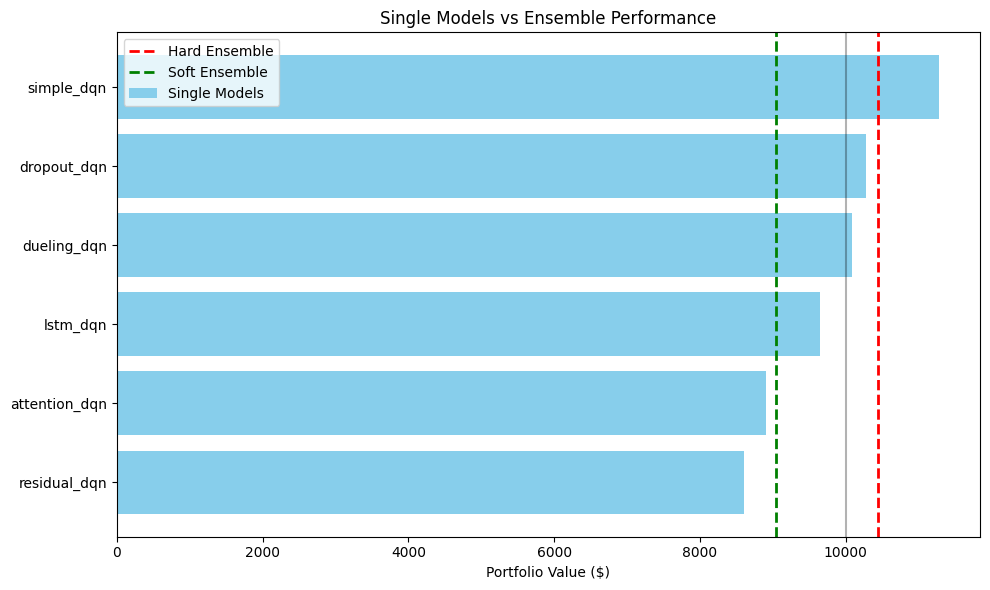

In [33]:
fig, ax = plt.subplots(figsize=(10, 6))

models_sorted = sorted(single_results.items(), key=lambda x: x[1])
names = [n for n, _ in models_sorted]
values = [v for _, v in models_sorted]

ax.barh(names, values, color='skyblue', label='Single Models')
ax.axvline(np.mean(hard_values), color='red', linestyle='--', linewidth=2, label='Hard Ensemble')
ax.axvline(np.mean(soft_values), color='green', linestyle='--', linewidth=2, label='Soft Ensemble')
ax.axvline(10000, color='black', linestyle='-', alpha=0.3)

ax.set_xlabel('Portfolio Value ($)')
ax.set_title('Single Models vs Ensemble Performance')
ax.legend()

plt.tight_layout()
plt.show()

## Save Ensemble Configuration

In [34]:
ensemble_config = {
    'models': list(models.keys()),
    'voting_methods': ['hard', 'soft'],
    'validation_results': {
        'hard_mean': float(np.mean(hard_values)),
        'hard_std': float(np.std(hard_values)),
        'soft_mean': float(np.mean(soft_values)),
        'soft_std': float(np.std(soft_values)),
        'best_single': best_single,
        'best_single_value': float(single_results[best_single])
    },
    'model_paths': model_paths
}

with open('models/ensemble_config.json', 'w') as f:
    json.dump(ensemble_config, f, indent=2)

print("Saved ensemble configuration")
recommendation = 'hard' if np.mean(hard_values) > np.mean(soft_values) else 'soft'
print(f"Recommendation: Use {recommendation} voting")

Saved ensemble configuration
Recommendation: Use hard voting
